In [34]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extract_to = "sms_spam_collection"
data_file_path = Path(extract_to) / "SMSSpamCollection"

def download_and_extract(url, zip_path, extract_to):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download.")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    original_file_path = Path(extract_to) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and extracted to {data_file_path}")

download_and_extract(url, zip_path, extract_to)

sms_spam_collection\SMSSpamCollection already exists. Skipping download.


In [35]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "message"])
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [36]:
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [37]:
def create_balanced_dataset(df):
    num_spam = df[df["label"] == "spam"].shape[0]
    ham_subset = df[df["label"] == "ham"].sample(n=num_spam, random_state=42)
    return pd.concat([ham_subset, df[df["label"] == "spam"]])

balanced_df = create_balanced_dataset(df)
print(balanced_df["label"].value_counts())

balanced_df["label"] = balanced_df["label"].map({"ham": 0, "spam": 1})

label
ham     747
spam    747
Name: count, dtype: int64


In [38]:
def random_split(df, train_frac, val_frac):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_end = int(train_frac * len(df))
    val_end = train_end + int(val_frac * len(df))
    return df[:train_end], df[train_end:val_end], df[val_end:]

train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.1)

dset_dir = Path("dataset")
if not dset_dir.exists():
    dset_dir.mkdir()

train_df.to_csv(dset_dir / "train.csv", index=False)
val_df.to_csv(dset_dir / "val.csv", index=False)
test_df.to_csv(dset_dir / "test.csv", index=False)


In [39]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [40]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["message"]
        ]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                enc[:max_length] for enc in self.encoded_texts    
            ]
        
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        return max(len(encoded) for encoded in self.encoded_texts)

train_dataset = SpamDataset(dset_dir / "train.csv",max_length=None, tokenizer=tokenizer)
print(train_dataset.max_length)
print(train_dataset.__len__())

val_dataset = SpamDataset(dset_dir / "val.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset(dset_dir / "test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

109
1045


In [41]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [42]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch shape:", input_batch.shape)
print("Target batch shape:", target_batch.shape)

Input batch shape: torch.Size([5, 109])
Target batch shape: torch.Size([5])


In [43]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

131 training batches
19 validation batches
38 test batches


In [44]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate":0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [45]:
from gpt_download import download_and_load_gpt2
from functions import GPTModel
from functions import load_weights_into_gpt
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
print(model)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MutiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)

In [46]:
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(BASE_CONFIG["emb_dim"], num_classes)
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0)ss
print("inputs:", inputs)
print("inputs shape:", inputs.shape)
with torch.no_grad():
    outputs = model(inputs)
print("outputs:\n", outputs)
print("outputs shape:", outputs.shape)

inputs: tensor([[5211,  345,  423,  640]])
inputs shape: torch.Size([1, 4])
outputs:
 tensor([[[-1.5883,  0.9920],
         [-3.7208,  7.4510],
         [-2.2642,  6.6005],
         [-3.5965,  3.9889]]])
outputs shape: torch.Size([1, 4, 2])


In [48]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        with torch.no_grad():
            logits = model(input_batch)[:, -1, :]
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == target_batch).sum().item()
        num_examples += target_batch.shape[0]
    return correct_predictions / num_examples if num_examples > 0 else 0.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"training accuracy: {train_accuracy*100:.2f}%")
print(f"validation accuracy: {val_accuracy*100:.2f}%")
print(f"test accuracy: {test_accuracy*100:.2f}%")

training accuracy: 46.25%
validation accuracy: 53.75%
test accuracy: 58.75%


In [49]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            examples_seen += input_batch.shape[0]  # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [50]:
import time
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.352, Val loss 2.258
Ep 1 (Step 000050): Train loss 0.641, Val loss 0.641
Ep 1 (Step 000100): Train loss 0.594, Val loss 0.580
Training accuracy: 77.50% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss 0.482, Val loss 0.474
Ep 2 (Step 000200): Train loss 0.327, Val loss 0.386
Ep 2 (Step 000250): Train loss 0.343, Val loss 0.257
Training accuracy: 95.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.415, Val loss 0.186
Ep 3 (Step 000350): Train loss 0.113, Val loss 0.153
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.068, Val loss 0.143
Ep 4 (Step 000450): Train loss 0.087, Val loss 0.148
Ep 4 (Step 000500): Train loss 0.025, Val loss 0.145
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.022, Val loss 0.137
Ep 5 (Step 000600): Train loss 0.028, Val loss 0.140
Ep 5 (Step 000650): Train loss 0.123, Val loss 0.148
Training accuracy: 100.00% | Val

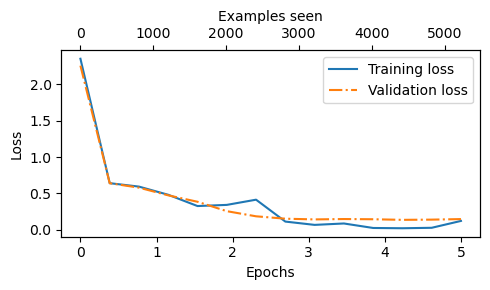

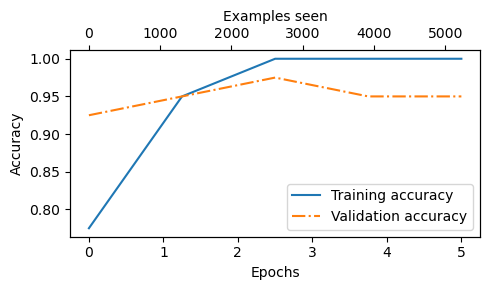

In [51]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

    # accuracy plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [52]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"training accuracy: {train_accuracy*100:.2f}%")
print(f"validation accuracy: {val_accuracy*100:.2f}%")
print(f"test accuracy: {test_accuracy*100:.2f}%")

training accuracy: 98.18%
validation accuracy: 95.30%
test accuracy: 96.00%
